<a href="https://colab.research.google.com/github/LauraHu820/5241_Machine_Learning/blob/main/assignment1_Yuchen_Hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ucimlrepo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from numpy.linalg import inv, eig
from sklearn.base import BaseEstimator
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
try:
    import statsmodels.api.add_constant
except ImportError:
    pass

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

# data (as pandas dataframes)
x = communities_and_crime.data.features
Y = communities_and_crime.data.targets
data = pd.concat([x, Y], axis=1)

# metadata
print(communities_and_crime.metadata)

# variable information
print(communities_and_crime.variables)

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

In [ ]:
# preprocessing
# 1. non-numeric features that doesn't have meaning: in this dataset, state, county, community,
# communityname and fold are categorical features.
# Though we can do one-hot encoding to convert them into numeric value, here the number of county,
# community are too big that will make our dataset be sparse if we use
# one-hot encoding. Also, they don't have predictive meaning. Thus, here I will drop those features.
df = data.drop(columns=['state', 'county', 'community', 'communityname', 'fold'])

# 2. missing value: for missing value "?", I choose to drop any rows with missing values
df1 = df.replace('?', np.nan)
df2 = df1.dropna()

# 3. change data type: for all values, change them into float datatype for later calculation
df3 = df2.apply(pd.to_numeric)

,0
population,float64
householdsize,float64
racepctblack,float64
racePctWhite,float64
racePctAsian,float64
...,...
LemasPctPolicOnPatr,float64
LemasGangUnitDeploy,float64
LemasPctOfficDrugUn,float64
PolicBudgPerPop,float64


In [ ]:
# center the data and standardize them
X = df3.drop(columns=['ViolentCrimesPerPop']).to_numpy()
Y = df3['ViolentCrimesPerPop'].to_numpy()

# Center data
Y_centered = Y - np.mean(Y)
X_centered = X - np.mean(X, axis=0)

# Standardize X (centered and scaled)
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X)

#Feature names
colnames = df3.drop(columns=['ViolentCrimesPerPop']).columns
n = X.shape[0]
colnames

Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up',
       ...
       'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans',
       'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop'],
      dtype='object', length=122)

In [ ]:
# Statistical significance via Least Squares.
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())
p = results.pvalues
p

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              29.04
Date:                Fri, 21 Feb 2025   Prob (F-statistic):                    1.42e-83
Time:                        00:21:39   Log-Likelihood:                          225.27
No. Observations:                 319   AIC:                                     -206.5
Df Residuals:                     197   BIC:                                      252.8
Df Model:                         122                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

array([0.18086069, 0.10382933, 0.90264758, 0.8258292 , 0.83839405,
       0.40990177, 0.97625529, 0.50864109, 0.90213473, 0.51666984,
       0.13812705, 0.35251466, 0.81815934, 0.3933054 , 0.07964195,
       0.01782755, 0.32786062, 0.211925  , 0.60699888, 0.27715662,
       0.25145514, 0.39781776, 0.18423844, 0.60350361, 0.27503859,
       0.30209653, 0.58798528, 0.16718891, 0.11490866, 0.75492394,
       0.11631787, 0.30988439, 0.24524427, 0.03487905, 0.04323255,
       0.78934729, 0.00419581, 0.04130133, 0.7937144 , 0.85594929,
       0.85626192, 0.69615418, 0.80345299, 0.15723567, 0.43413423,
       0.31363937, 0.49439816, 0.38206922, 0.76213494, 0.61015776,
       0.87591175, 0.19975989, 0.24534426, 0.33692666, 0.38159653,
       0.05416418, 0.58593273, 0.76255375, 0.02659605, 0.00382521,
       0.18572655, 0.16120254, 0.3633315 , 0.20470494, 0.57516212,
       0.17180869, 0.1369376 , 0.28477257, 0.03971231, 0.08702678,
       0.82866238, 0.44398758, 0.5380336 , 0.15273008, 0.70725

As we can see, the p_value for X_34, X_35, X_37, X_38, X_59, X_60, X_69, X_79, X_83, X_91 are smaller than 0.05, which indicate these features are statistically significant. These features are: PctEmploy, PctEmplManu, PctOccupManu, PctOccupMgmtProf, PctRecImmig8, PctRecImmig10, PctPersDenseHous, PctWOFullPlumb, RentLowQ, NumStreet

In [ ]:
# Best Subsets

# Define a linear regression model
linear_reg = LinearRegression()

#Obtain exhaustive mse values
efs = EFS(
    linear_reg,
    min_features=1,
    max_features=3,
    scoring="neg_mean_squared_error", #we use negative mse since the sfs method maximizes the score
    cv=0,
    n_jobs=-1
)
efs.fit(X, Y)

#Obtain a summary of the exhaustive results (all possible models)
efs_summary = pd.DataFrame.from_dict(efs.get_metric_dict()).T[["feature_idx", "avg_score"]]
efs_summary["feature_idx"]
efs_size = np.zeros(len(efs_summary))
for i in range(len(efs_summary)):
    efs_size[i] = len(efs_summary["feature_idx"][i])
efs_summary['model size'] = efs_size
efs_summary.rename(columns={'avg_score': 'neg_mse'}, inplace=True)
print("The first few results for exhaustive feature selection (all possible models) look like:")
print(efs_summary.iloc[range(15)].to_string(index=False))

Features: 302743/302743

The first few results for exhaustive feature selection (all possible models) look like:
feature_idx   neg_mse  model size
       (0,) -0.068566         1.0
       (1,) -0.075828         1.0
       (2,) -0.043109         1.0
       (3,) -0.038937         1.0
       (4,) -0.075704         1.0
       (5,) -0.074477         1.0
       (6,) -0.072796         1.0
       (7,) -0.073915         1.0
       (8,) -0.074177         1.0
       (9,)  -0.07607         1.0
      (10,) -0.068551         1.0
      (11,) -0.075981         1.0
      (12,)  -0.05509         1.0
      (13,) -0.067675         1.0
      (14,) -0.070968         1.0


In [ ]:
#code to calculate model evaluation criteria for all models in efs_summary

#code to calculate sigma hat squared for Mallows Cp calculation
X_with_const = sm.tools.tools.add_constant(X)
model = sm.regression.linear_model.OLS(Y, X_with_const).fit()
sigma_hat_squared = np.sum(model.resid ** 2) / (len(Y) - len(X[0])) #intercept not counted as predictor
#code to calculate total sum of squares, used for r2 calculation:
Y_mean = np.mean(Y)
tss = sum((Y - np.full(len(Y), Y_mean))**2)

prederror = np.zeros((len(efs_summary),4))
for i in range(len(efs_summary)):
    rss = -efs_summary.iloc[i,1]*len(X)
    p = efs_summary.iloc[i,2]
    n = len(X)
    aic = 2*p + n * np.log(rss/n)
    bic = p * np.log(n) + n * np.log(rss/n)
    mallows_cp = (rss / sigma_hat_squared) - n + 2 * p
    r2 = 1 - rss/tss
    adjr2 = 1 - (1 - r2)*(n-1)/(n-p-1)
    prederror[i,0] = bic
    prederror[i,1] = adjr2
    prederror[i,2] = mallows_cp
    prederror[i,3] = aic

efs_summary['bic'] = prederror[:,0]
efs_summary['adjr2'] = prederror[:,1]
efs_summary['cp'] = prederror[:,2]
efs_summary['aic'] = prederror[:,3]
print(efs_summary.iloc[0:15,:].to_string(index=False))

feature_idx   neg_mse  model size          bic     adjr2         cp          aic
       (0,) -0.068566         1.0  -849.142052  0.096519 645.098264  -852.907243
       (1,) -0.075828         1.0  -817.026232  0.000824 747.002630  -820.791423
       (2,) -0.043109         1.0  -997.175731  0.431956 287.898800 -1000.940922
       (3,) -0.038937         1.0 -1029.650289  0.486937 229.350138 -1033.415480
       (4,) -0.075704         1.0  -817.548496  0.002458 745.262078  -821.313687
       (5,) -0.074477         1.0  -822.761911  0.018629 728.042627  -826.527103
       (6,) -0.072796         1.0  -830.046957  0.040786 704.447299  -833.812148
       (7,) -0.073915         1.0  -825.176528  0.026029 720.162217  -828.941719
       (8,) -0.074177         1.0  -824.049570  0.022582 723.832767  -827.814761
       (9,)  -0.07607         1.0  -816.012999 -0.002355 750.387572  -819.778190
      (10,) -0.068551         1.0  -849.211774  0.096717 644.888007  -852.976965
      (11,) -0.075981       

In [ ]:
best_model = [None] * 3
best_model[0] = efs_summary.iloc[int(efs_summary['bic'].idxmin()),0]
best_model[1] = efs_summary.iloc[int(efs_summary['adjr2'].idxmax()),0]
best_model[2] = efs_summary.iloc[int(efs_summary['cp'].idxmin()),0]
best_model_display = pd.DataFrame([best_model], columns=["BIC", "Adj R2", "CP"])
print(best_model_display.to_string(index=False))

     BIC   Adj R2       CP
(44, 90) (44, 90) (44, 90)


In [ ]:
print("The best model for each criterion is:")
print("BIC: " + str(np.array(colnames)[np.array(best_model_display['BIC'][0])]))
print("Adj R2: " + str(np.array(colnames)[np.array(best_model_display['Adj R2'][0])]))
print("Cp: " + str(np.array(colnames)[np.array(best_model_display['CP'][0])]))

The best model for each criterion is:
BIC: ['PctKids2Par' 'NumStreet']
Adj R2: ['PctKids2Par' 'NumStreet']
Cp: ['PctKids2Par' 'NumStreet']


Since the best subset methods requiare too much time for computation, plus the feature number is big (over 100), here I only select the subset of 2 for the selection.

step-wise approach

In [ ]:

def calculate_aic(estimator, X, y):
    n, k = X.shape
    y_pred = estimator.predict(X)
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return -aic

def aic_scorer_wrapper(estimator, X, y):
    estimator.fit(X, y)
    return calculate_aic(estimator, X, y)

In [ ]:
model = LinearRegression()
sfs_forward = SFS(
    model,
    k_features='best',
    forward=True,
    floating=False,
    scoring=aic_scorer_wrapper,
    cv=0  # No cross-validation
)

sfs_forward.fit(X_standardized,Y_centered)

print("Selected features:", np.array(colnames)[np.array(sfs_forward.k_feature_names_, dtype=int)])
print(pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T[["feature_idx", "avg_score"]])

Selected features: ['householdsize' 'racePctWhite' 'agePct16t24' 'medIncome' 'pctWWage'
 'pctWFarmSelf' 'pctWInvInc' 'whitePerCap' 'OtherPerCap' 'PctLess9thGrade'
 'PctNotHSGrad' 'PctUnemployed' 'PctEmploy' 'PctEmplManu' 'PctOccupManu'
 'PctOccupMgmtProf' 'TotalPctDiv' 'PersPerFam' 'PctKids2Par' 'NumImmig'
 'PctSpeakEnglOnly' 'PctNotSpeakEnglWell' 'PctLargHouseFam'
 'PersPerOccupHous' 'PersPerRentOccHous' 'PctPersDenseHous'
 'PctHousLess3BR' 'PctWOFullPlumb' 'OwnOccLowQuart' 'RentLowQ' 'MedRent'
 'MedOwnCostPctInc' 'MedOwnCostPctIncNoMtg' 'NumStreet' 'PctBornSameState'
 'PctSameState85' 'PolicReqPerOffic' 'RacialMatchCommPol' 'PctPolicAsian'
 'PctUsePubTrans' 'PolicCars' 'LemasGangUnitDeploy' 'LemasPctOfficDrugUn']
                                           feature_idx    avg_score
1                                                (44,)  1093.183936
2                                             (44, 90)  1130.570344
3                                          (3, 44, 90)  1152.404795
4  

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
model = LinearRegression()
sfs_backward = SFS(
    model,
    k_features='best',
    forward=False,
    floating=False,
    scoring=aic_scorer_wrapper,  # Use custom AIC scorer
    cv=0  # No cross-validation, evaluate on the whole dataset
)

sfs_backward.fit(X_standardized,Y_centered)

print("Selected features:", np.array(colnames)[np.array(sfs_backward.k_feature_names_, dtype=int)])
print(pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T[["feature_idx", "avg_score"]])

Selected features: ['householdsize' 'racePctHisp' 'agePct12t29' 'numbUrban' 'pctWInvInc'
 'medFamInc' 'perCapInc' 'AsianPerCap' 'NumUnderPov' 'PctPopUnderPov'
 'PctNotHSGrad' 'PctBSorMore' 'PctEmploy' 'PctEmplManu' 'PctOccupManu'
 'PctOccupMgmtProf' 'TotalPctDiv' 'PctFam2Par' 'PctWorkMomYoungKids'
 'PctImmigRec8' 'PctImmigRec10' 'PctRecImmig8' 'PctRecImmig10'
 'PctLargHouseOccup' 'PersPerRentOccHous' 'PctPersDenseHous'
 'PctHousLess3BR' 'PctWOFullPlumb' 'OwnOccMedVal' 'OwnOccHiQuart'
 'RentLowQ' 'MedRent' 'MedOwnCostPctInc' 'NumStreet' 'PctForeignBorn'
 'LemasSwFTPerPop' 'LemasTotReqPerPop' 'PolicPerPop' 'RacialMatchCommPol'
 'PctPolicAsian' 'OfficAssgnDrugUnits' 'PctUsePubTrans' 'PolicCars']
                                           feature_idx    avg_score
122  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1116.813446
121  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1118.810487
120  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1120.805373
119  (0, 1, 2, 4, 5, 6, 7,

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
fit0 = LinearRegression()
fit0.fit(X_standardized, Y_centered)

lasso = Lasso(fit_intercept=False, alpha=0.01)
lasso.fit(X_standardized, Y_centered)
print(pd.DataFrame(np.stack((colnames, fit0.coef_, lasso.coef_), axis=1), columns=["Variables", "Without L1","With L1"]))

               Variables Without L1   With L1
0             population   -0.84393       0.0
1          householdsize   0.163653       0.0
2           racepctblack  -0.013156  0.004016
3           racePctWhite     0.0057 -0.050353
4           racePctAsian  -0.020609      -0.0
..                   ...        ...       ...
117        PolicOperBudg   0.093341       0.0
118  LemasPctPolicOnPatr  -0.035137       0.0
119  LemasGangUnitDeploy   0.003829  0.007975
120  LemasPctOfficDrugUn  -0.011094 -0.002357
121      PolicBudgPerPop  -0.046973       0.0

[122 rows x 3 columns]


In [ ]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
mse = {}
for i, lamb in enumerate(lambdas):
    lasso = Lasso(alpha = lamb)
    lasso.fit(X_standardized, Y_centered)
    mse[lamb] = np.mean((Y_centered - lasso.predict(X_standardized))**2)

min(mse, key=mse.get)


0.010000000000000004

In [ ]:
lasso = Lasso(fit_intercept=False, alpha=0.01)
lasso.fit(X_standardized, Y_centered)
temp_feature = np.stack((colnames, lasso.coef_), axis=1)
feature_lasso = temp_feature[temp_feature[:,1] != 0]
list_lasso = feature_lasso[:,0]
list_lasso

array(['racepctblack', 'racePctWhite', 'pctWInvInc', 'PctUnemployed',
       'PctEmploy', 'PctEmplManu', 'TotalPctDiv', 'PctFam2Par',
       'PctKids2Par', 'PctIlleg', 'PctHousLess3BR', 'PctHousOccup',
       'PctVacantBoarded', 'NumStreet', 'PolicReqPerOffic',
       'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicAsian',
       'PolicCars', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn'],
      dtype=object)

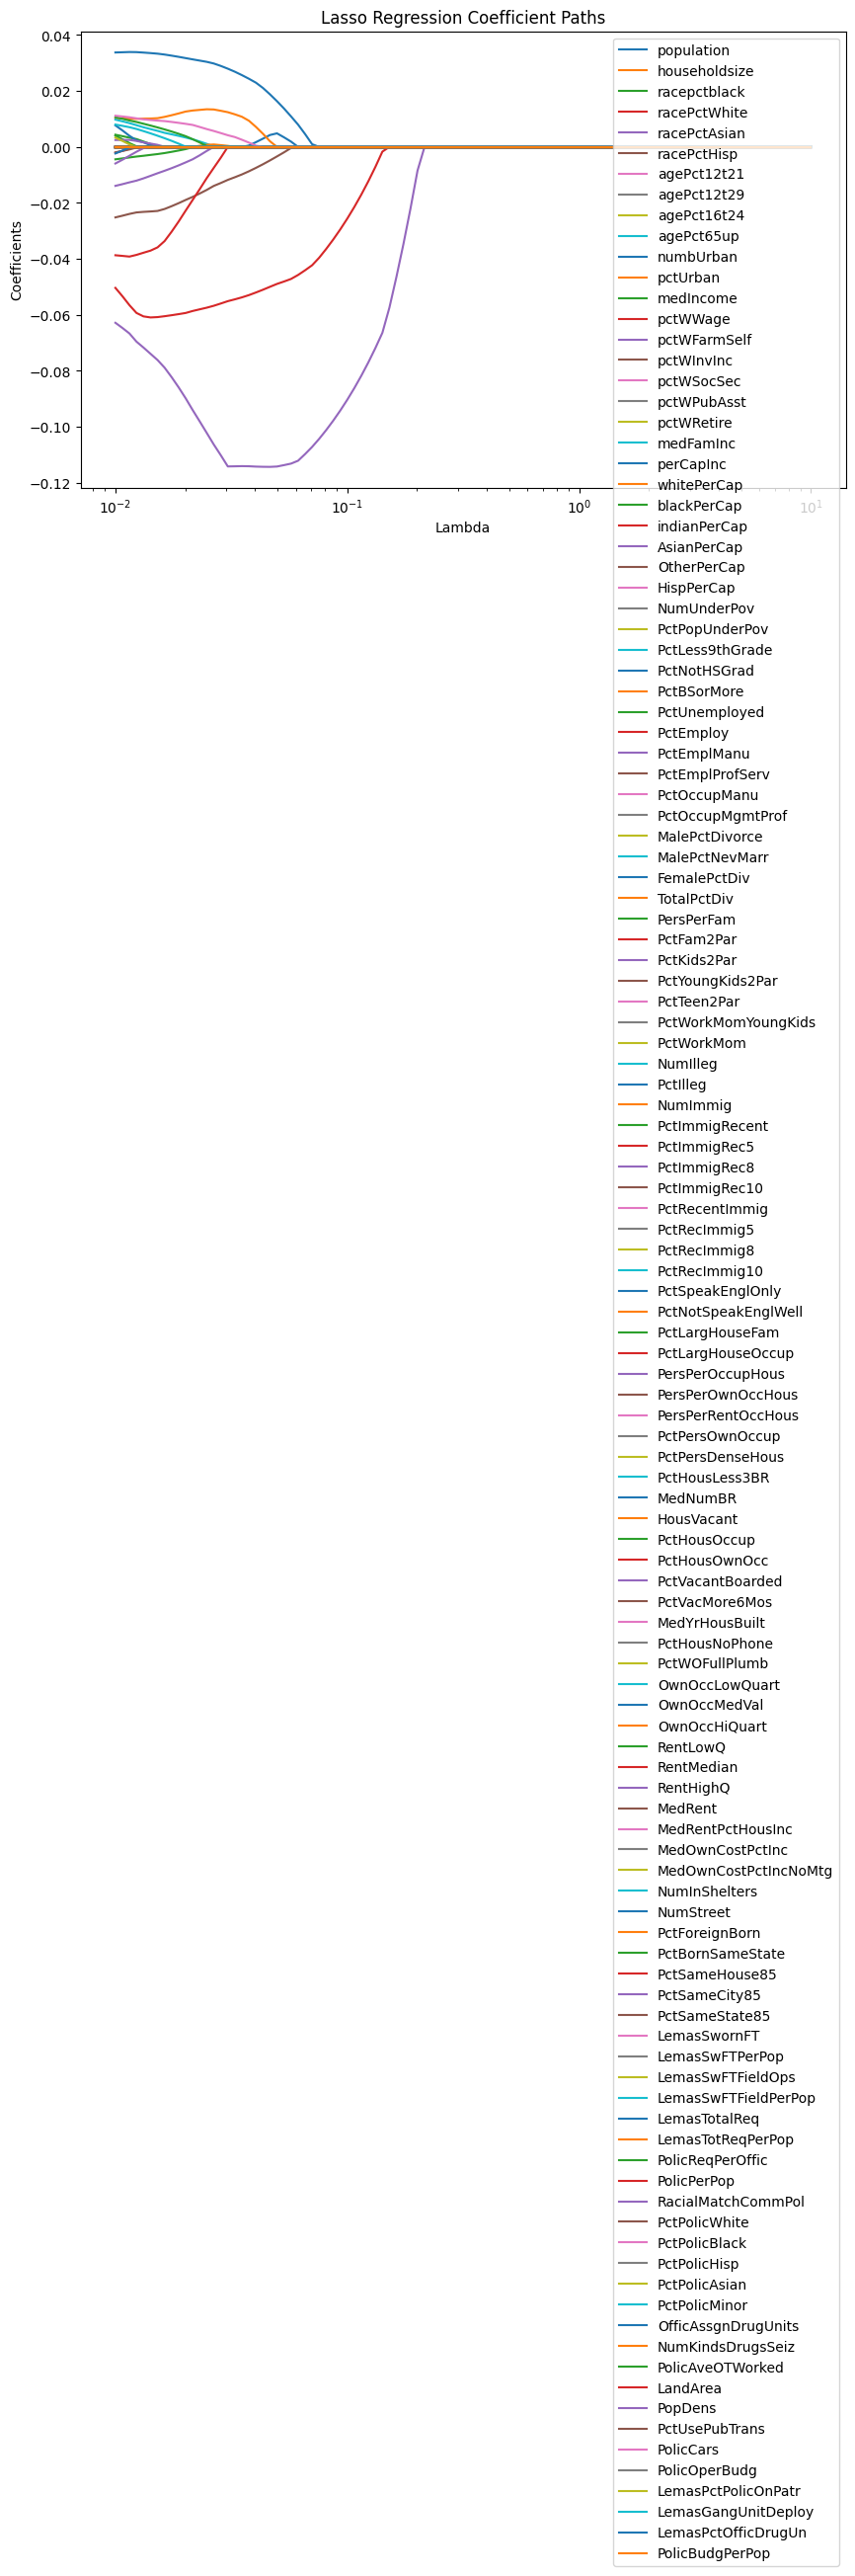

In [ ]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
betasl = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    lasso = Lasso(alpha = lamb)
    lasso.fit(X_standardized, Y_centered)
    betasl[i, :] = lasso.coef_

# Plot Lasso paths (log-scale)
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]): #for each variable
    plt.plot(lambdas, betasl[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Lasso Regression Coefficient Paths")
plt.legend(colnames)
plt.show()

In [ ]:
lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
l1ratios = np.array([0, 0.33, 0.66, 1])

mse_L1ratios = {}

for l1ratio in l1ratios:
    betase = np.zeros((len(lambdas), X.shape[1]))
    mse_lambda = {}
    for i, lamb in enumerate(lambdas):
        elasticnet = ElasticNet(alpha=lamb, l1_ratio = l1ratio, fit_intercept=False)
        elasticnet.fit(X_standardized, Y_centered)
        mse_lambda[lamb] = np.mean((Y_centered - elasticnet.predict(X_standardized))**2)
    mse_L1ratios[l1ratio] = (min(mse_lambda, key=mse_lambda.get), mse_lambda[min(mse_lambda, key=mse_lambda.get)])





In [ ]:
mse_L1ratios

{0.0: (0.010000000000000004, 0.016068394292080873),
 0.33: (0.010000000000000004, 0.021414644320372465),
 0.66: (0.010000000000000004, 0.023174353877194485),
 1.0: (0.010000000000000004, 0.02417914458351679)}

In [ ]:
elasticnet = ElasticNet(alpha=0.01, l1_ratio = 0.33, fit_intercept=False)
elasticnet.fit(X_standardized, Y_centered)
print(np.mean((Y_centered - elasticnet.predict(X_standardized))**2))
temp = np.stack((colnames, elasticnet.coef_), axis=1)
temp_feature = temp[temp[:,1] != 0]
list_elasticnet = temp_feature[:,0]
list_elasticnet

0.021414644320372465


array(['racePctWhite', 'racePctHisp', 'agePct12t29', 'pctWFarmSelf',
       'pctWInvInc', 'pctWRetire', 'blackPerCap', 'indianPerCap',
       'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctLess9thGrade',
       'PctUnemployed', 'PctEmplManu', 'PctFam2Par', 'PctKids2Par',
       'PctIlleg', 'PctImmigRec10', 'PersPerOwnOccHous',
       'PersPerRentOccHous', 'PctPersOwnOccup', 'PctHousLess3BR',
       'HousVacant', 'PctVacantBoarded', 'PctWOFullPlumb',
       'OwnOccLowQuart', 'RentLowQ', 'MedOwnCostPctInc', 'NumStreet',
       'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85',
       'PctSameState85', 'PolicReqPerOffic', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicAsian', 'PolicAveOTWorked',
       'PctUsePubTrans', 'PolicCars', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'LemasPctOfficDrugUn'], dtype=object)

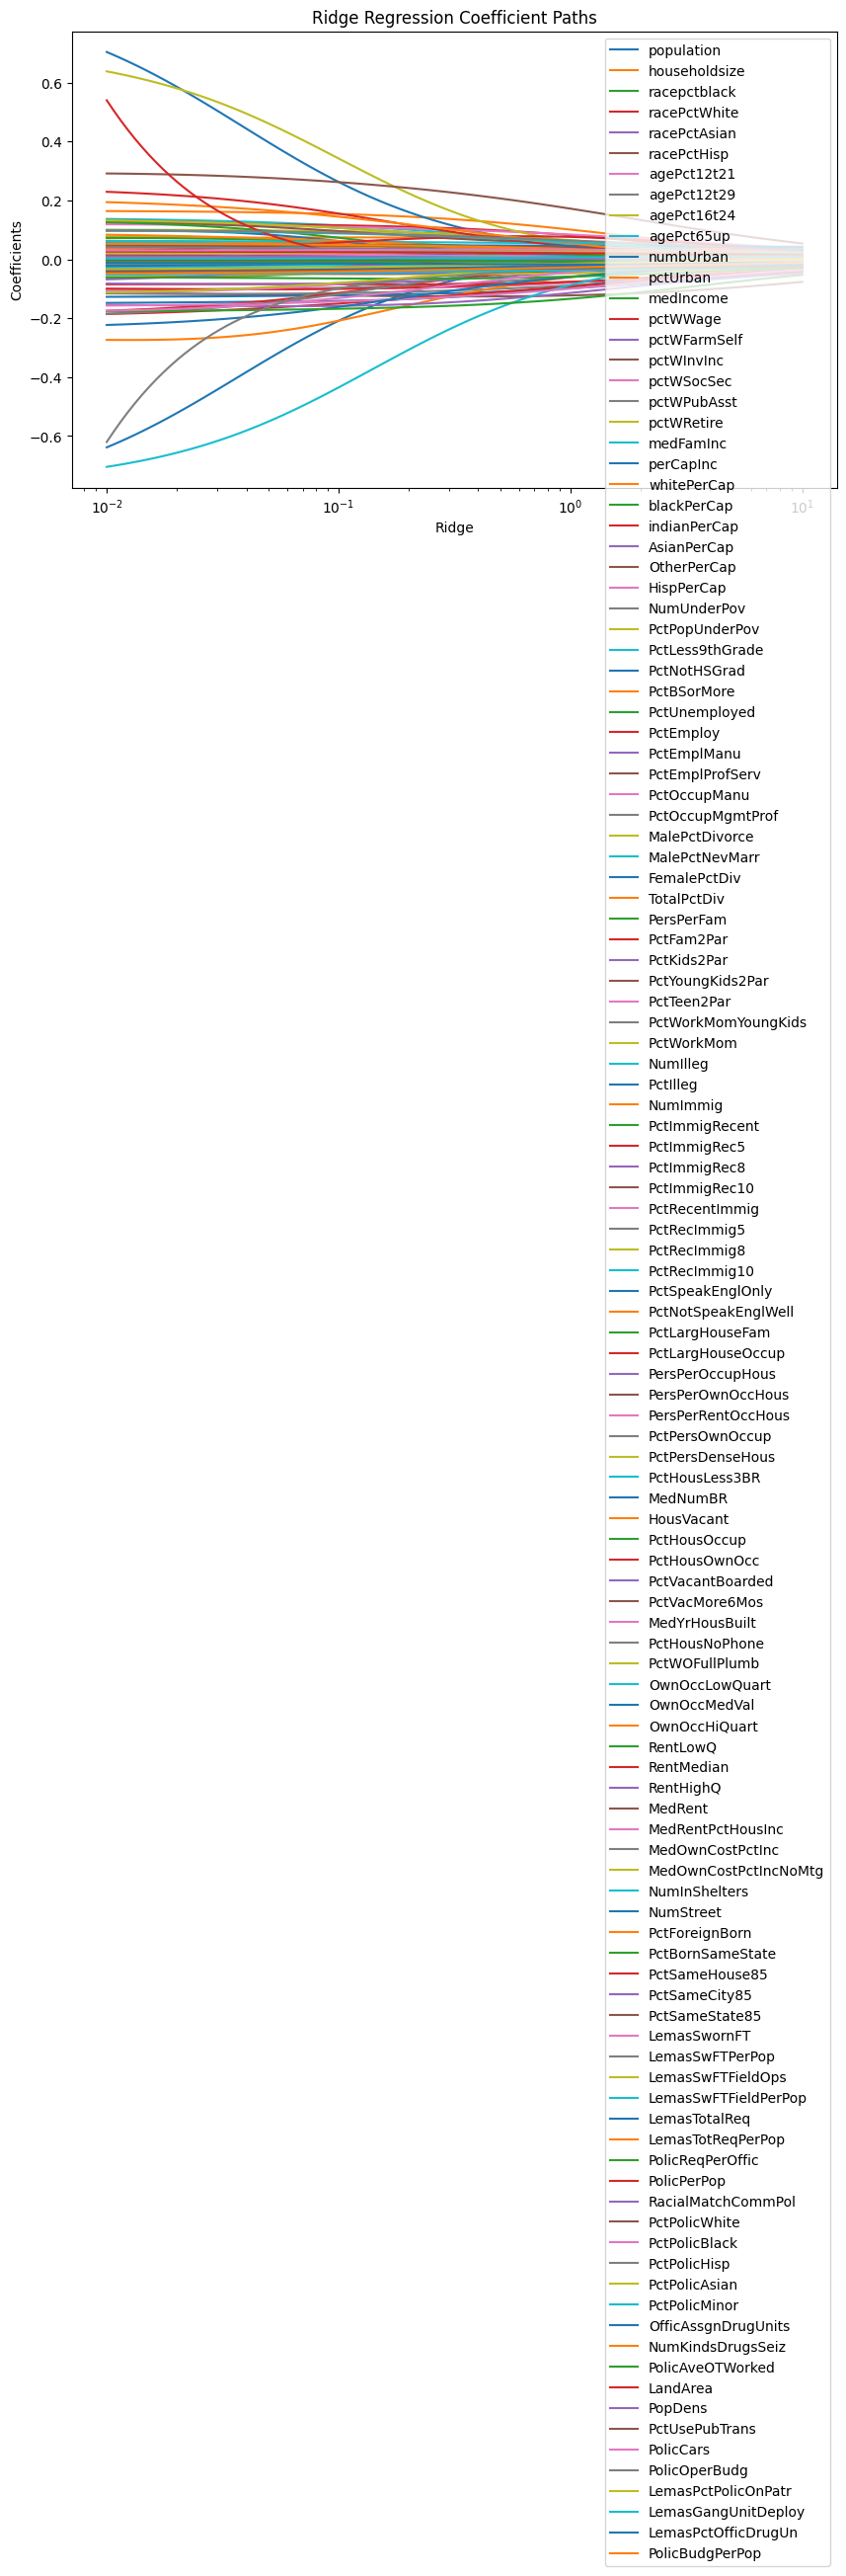

In [ ]:
m = Ridge(alpha=0.01)
m.fit(X_standardized, Y_centered)
temp1 = np.stack((colnames, m.coef_), axis=1)

lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
betasl = np.zeros((len(lambdas), X.shape[1]))
for i, lamb in enumerate(lambdas):
    ridge = Ridge(alpha = lamb)
    ridge.fit(X_standardized, Y_centered)
    betasl[i, :] = ridge.coef_

# Plot Lasso paths (log-scale)
plt.figure(figsize=(10, 6))
for j in range(X_standardized.shape[1]): #for each variable
    plt.plot(lambdas, betasl[:, j], label=f"Variable {j+1}")
plt.xscale("log")
plt.xlabel("Ridge")
plt.ylabel("Coefficients")
plt.title("Ridge Regression Coefficient Paths")
plt.legend(colnames)
plt.show()

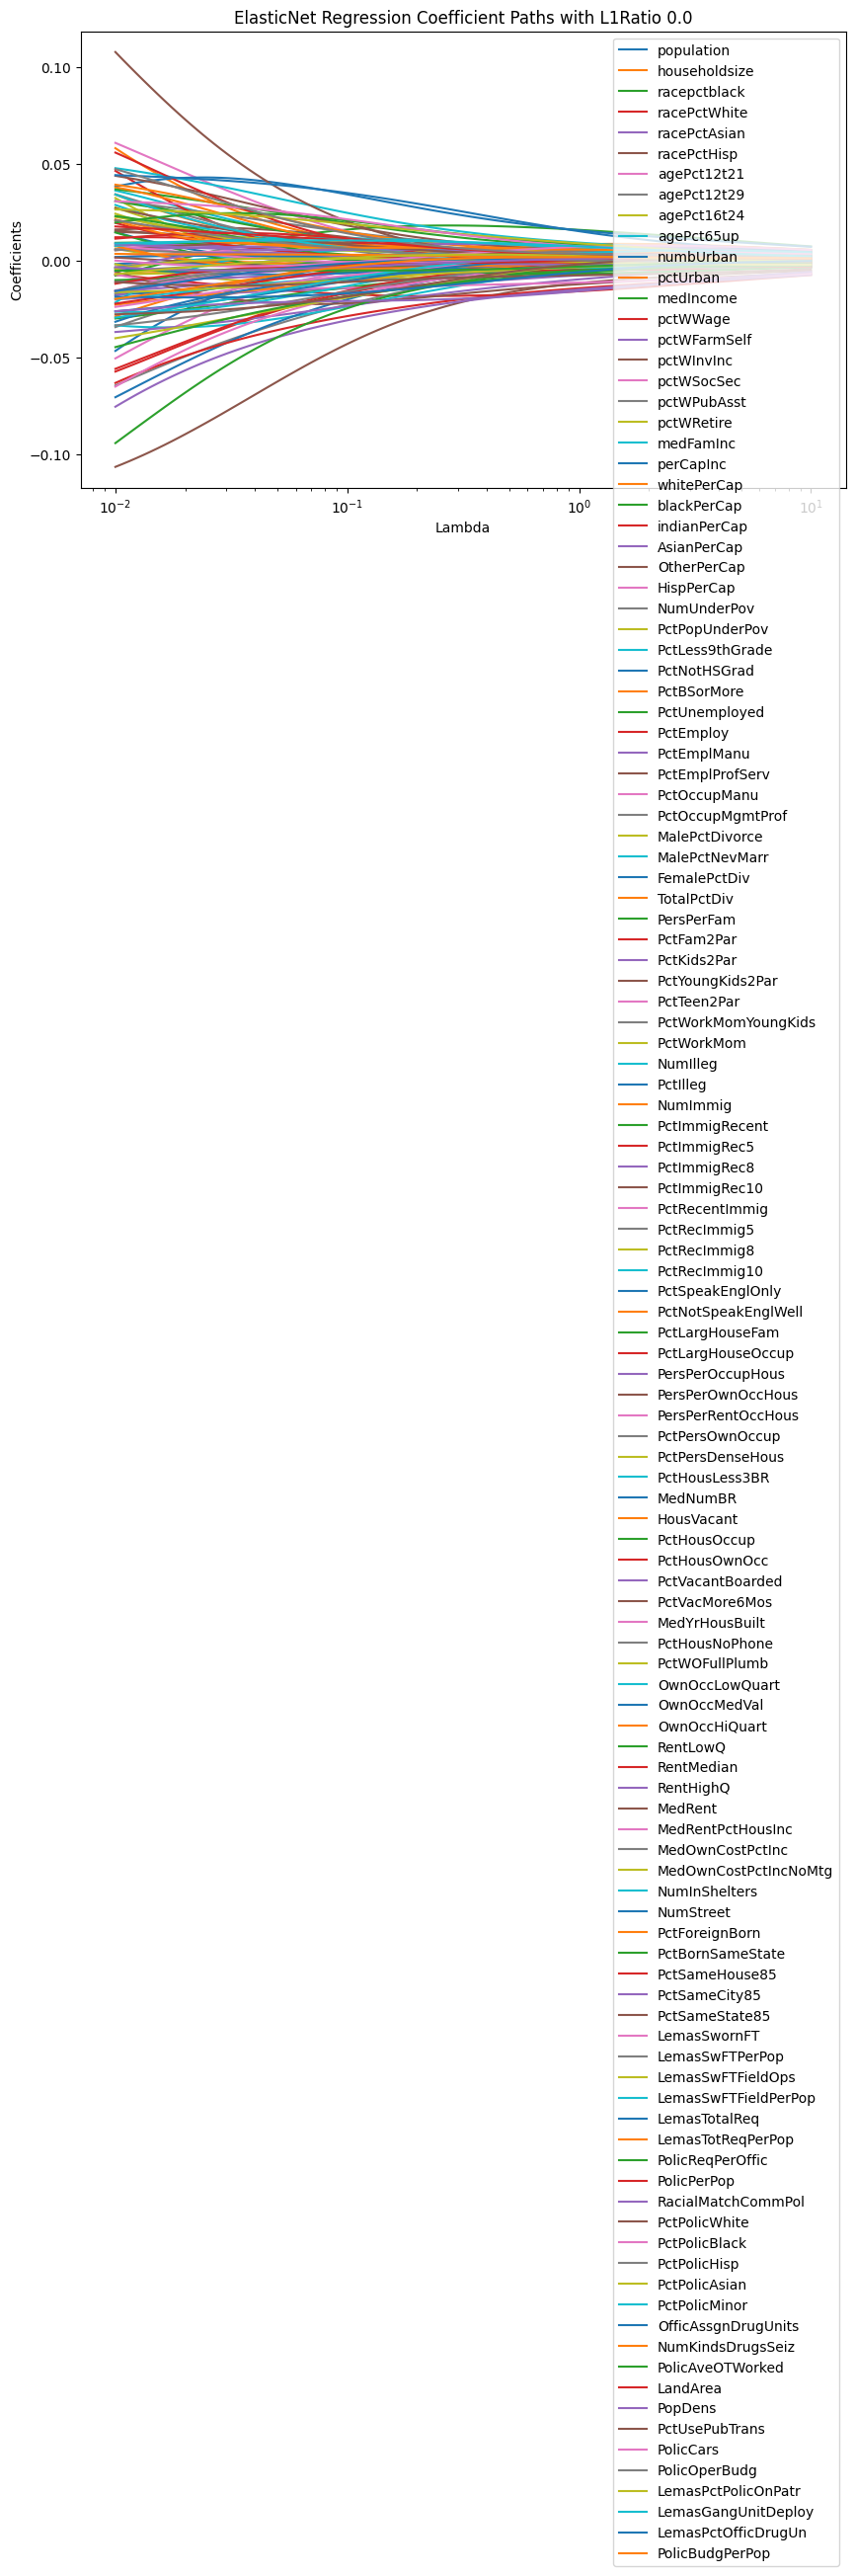

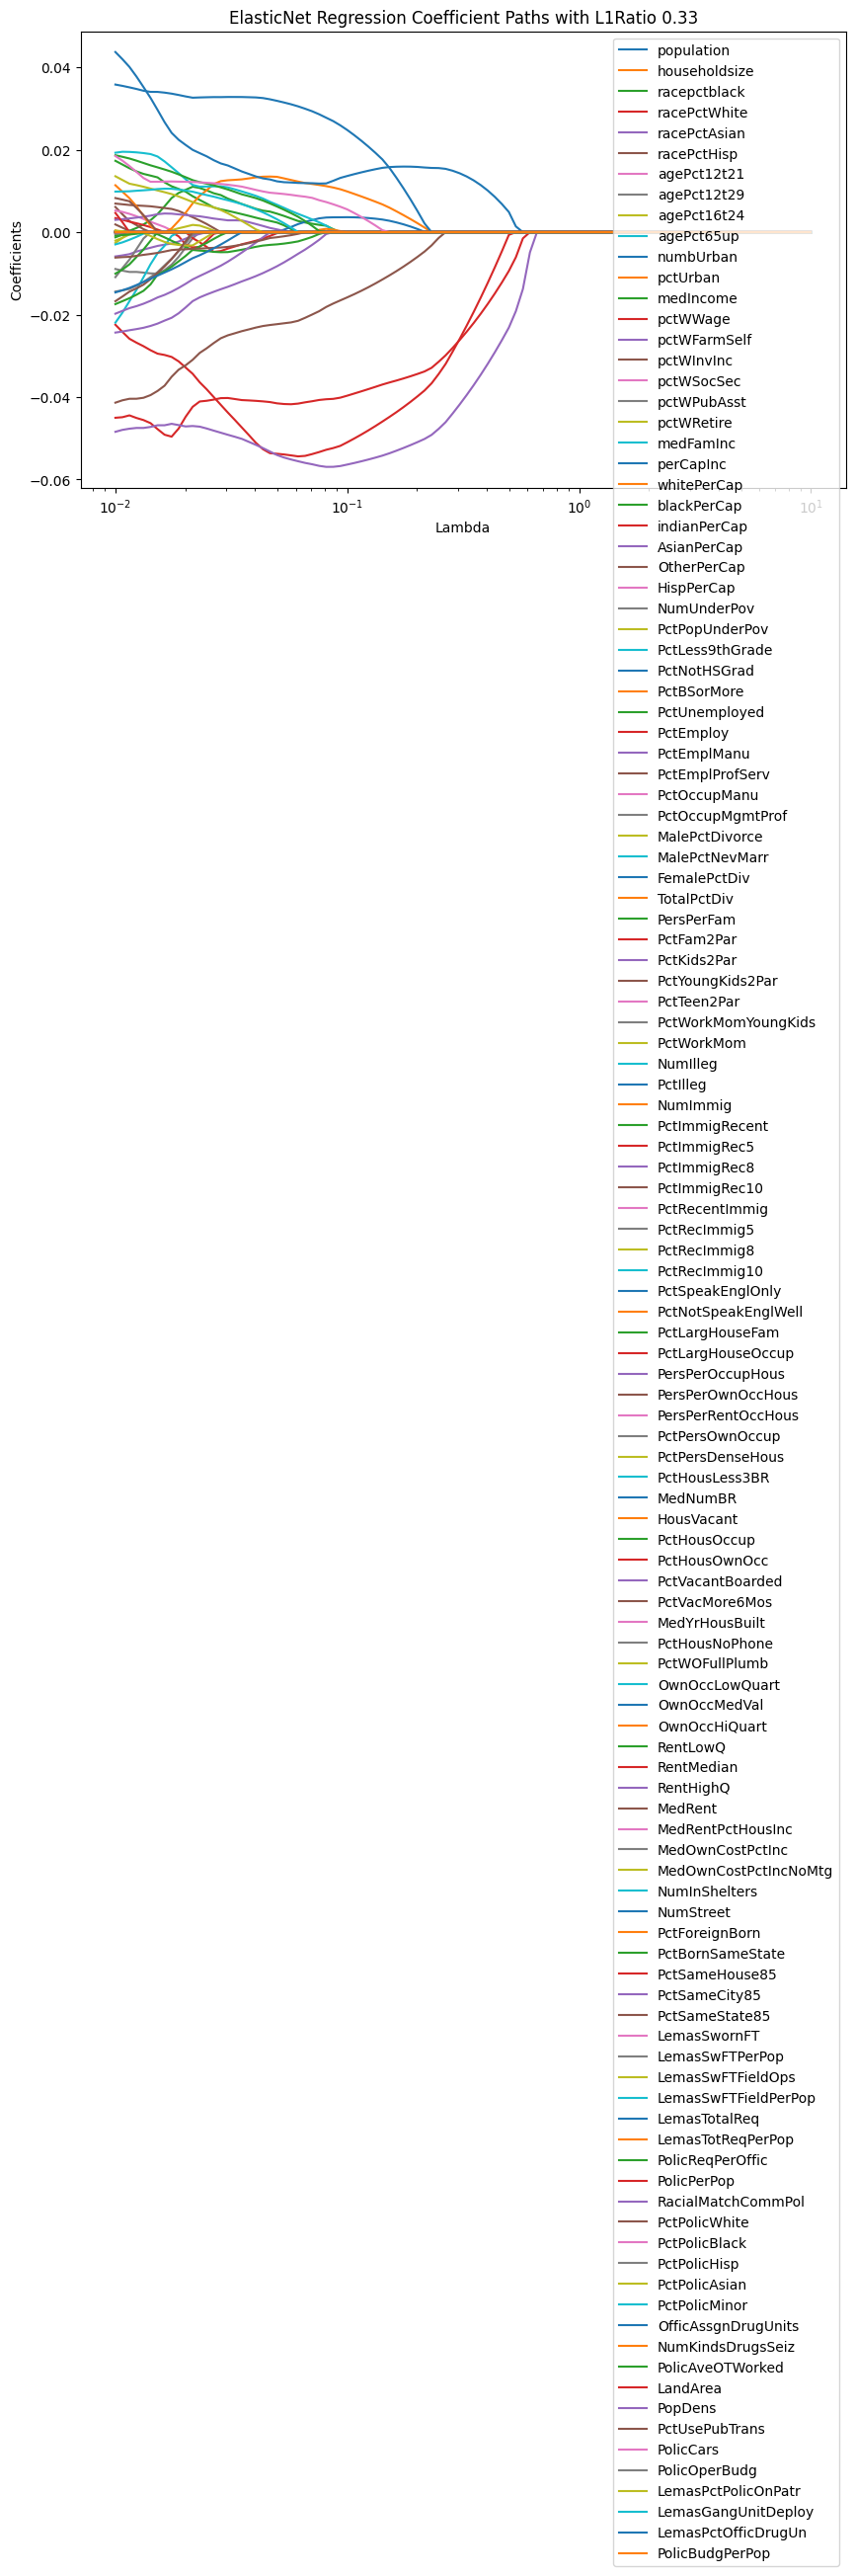

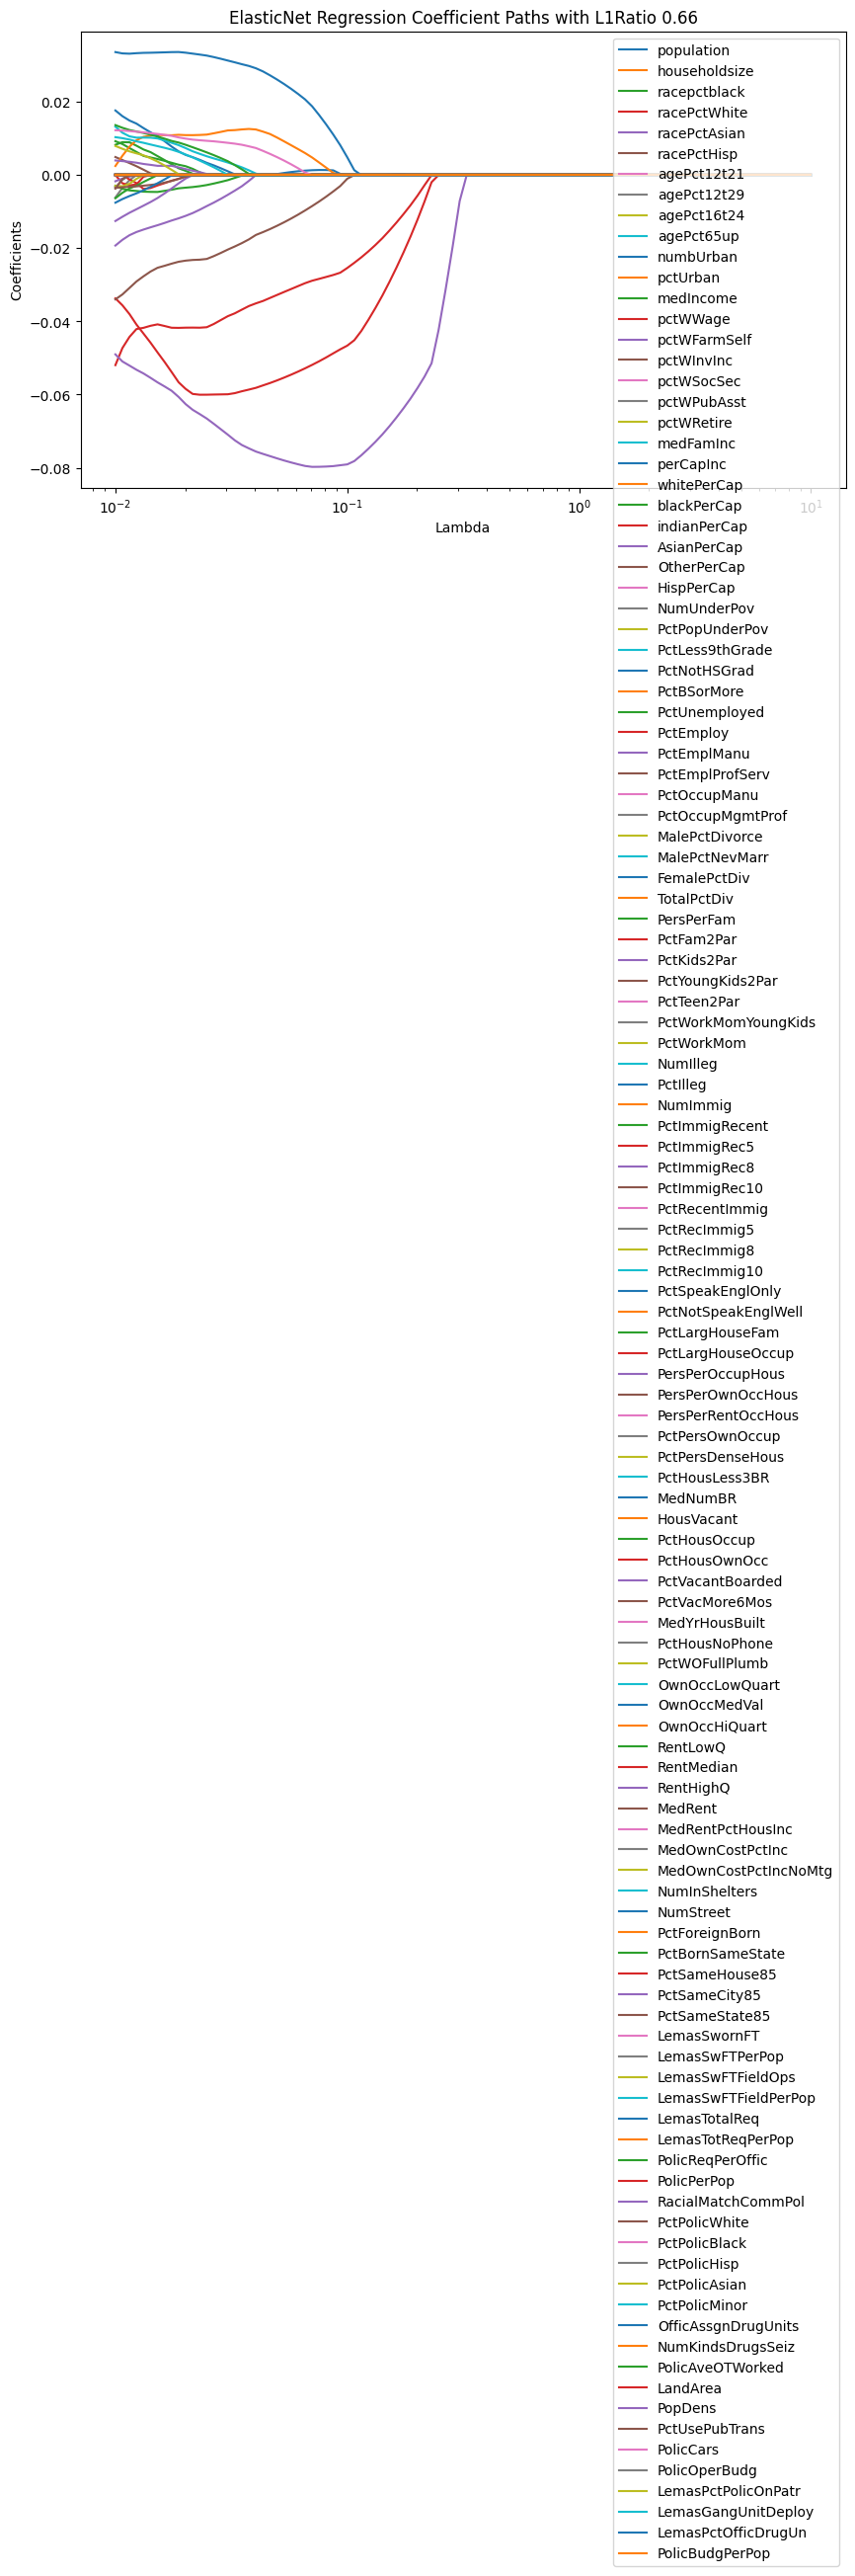

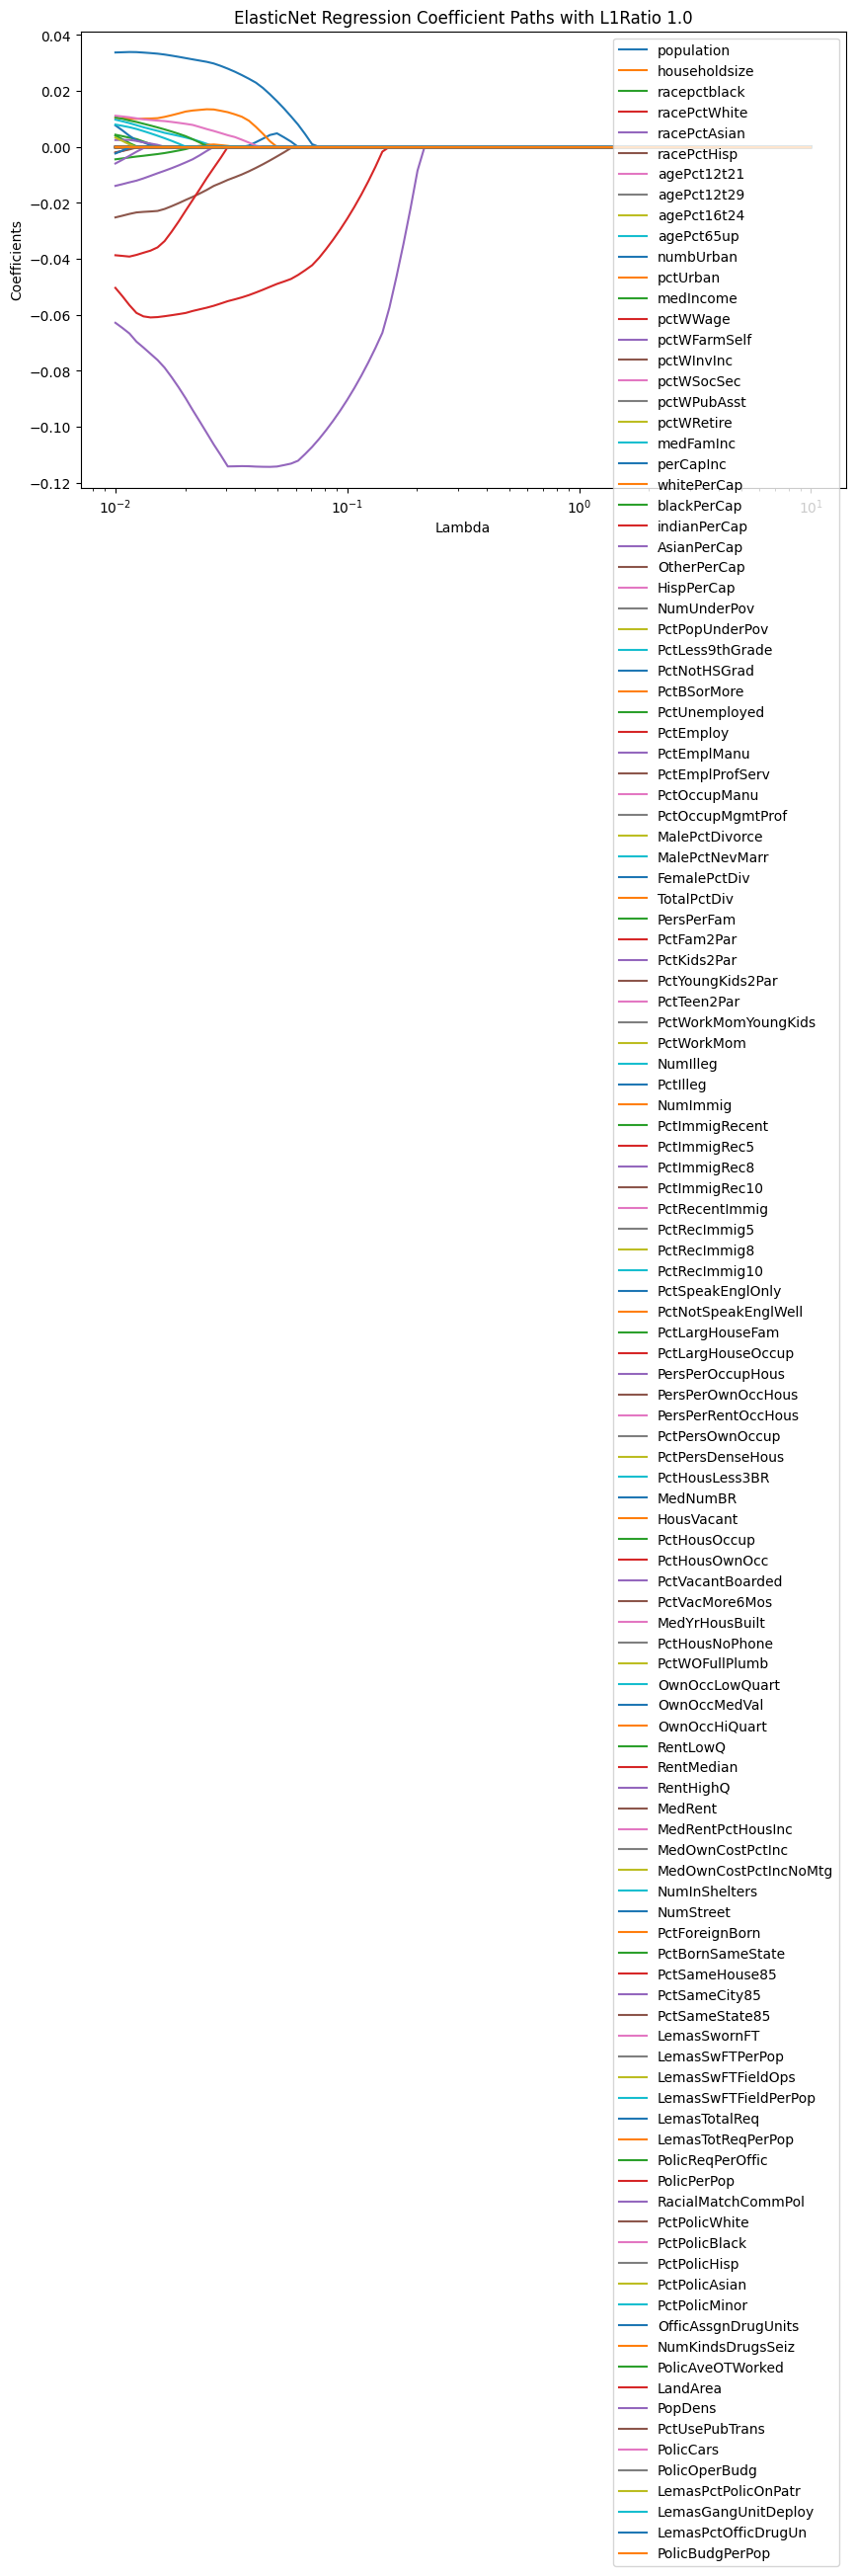

In [ ]:
import warnings
warnings.filterwarnings("ignore")

lambdas = np.exp(np.linspace(np.log(0.01), np.log(10), 100))
l1ratios = np.array([0, 0.33, 0.66, 1])
coefs = pd.DataFrame()
for l1ratio in l1ratios:
    betase = np.zeros((len(lambdas), X.shape[1]))
    for i, lamb in enumerate(lambdas):
        elasticnet = ElasticNet(alpha=lamb, l1_ratio = l1ratio, fit_intercept=False)
        elasticnet.fit(X_standardized, Y_centered)
        betase[i, :] = elasticnet.coef_

    # Plot Lasso paths (log-scale)
    plt.figure(figsize=(10, 6))
    for j in range(X_standardized.shape[1]): #for each variable
        plt.plot(lambdas, betase[:, j], label=f"Variable {j+1}")

    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Coefficients")
    plt.title("ElasticNet Regression Coefficient Paths with L1Ratio " + str(l1ratio))
    plt.legend(colnames)
    plt.show()
    elasticnet = ElasticNet(alpha=1, l1_ratio = l1ratio, fit_intercept=False)
    elasticnet.fit(X_standardized, Y_centered)
    coefs[l1ratio] = elasticnet.coef_

In [ ]:
coefs_df = pd.DataFrame(coefs)
coefs_df.insert(0, 'Variables', colnames)
print("The coefficients of each l1ratio at regularization parameter 1 are")
print(coefs_df.to_string(index=False))

The coefficients of each l1ratio at regularization parameter 1 are
            Variables       0.0  0.33  0.66  1.0
           population -0.000538   0.0   0.0  0.0
        householdsize  0.000921   0.0   0.0  0.0
         racepctblack  0.015858   0.0   0.0  0.0
         racePctWhite -0.015859  -0.0  -0.0 -0.0
         racePctAsian  0.000797  -0.0  -0.0 -0.0
          racePctHisp  0.001658   0.0   0.0  0.0
          agePct12t21  0.002735   0.0   0.0  0.0
          agePct12t29 -0.002153   0.0   0.0  0.0
          agePct16t24 -0.000319   0.0   0.0  0.0
           agePct65up  0.002687  -0.0  -0.0 -0.0
            numbUrban -0.000410   0.0   0.0  0.0
             pctUrban  0.001092   0.0   0.0  0.0
            medIncome -0.003019  -0.0  -0.0 -0.0
             pctWWage -0.005528  -0.0  -0.0 -0.0
         pctWFarmSelf -0.007648  -0.0  -0.0 -0.0
           pctWInvInc -0.011675  -0.0  -0.0 -0.0
           pctWSocSec  0.001058   0.0   0.0  0.0
          pctWPubAsst  0.006324   0.0   0.0  0.0
  

In [ ]:
list1 = np.array(['PctEmploy', 'PctEmplManu', 'PctOccupManu', 'PctOccupMgmtProf', 'PctRecImmig8', 'PctRecImmig10', 'PctPersDenseHous', 'PctWOFullPlumb', 'RentLowQ', 'NumStreet'])
list2 = np.array(colnames)[np.array(sfs_backward.k_feature_names_, dtype=int)]
list3 = np.array(colnames)[np.array(sfs_forward.k_feature_names_, dtype=int)]
list4 = np.array(list_elasticnet)
list5 = np.array(list_lasso)
result = np.append(list2, list1)
results = np.append(result, list3)
results = np.append(results, list4)
results = np.append(results, list5)
results = np.unique(results, return_counts=True)
count = pd.DataFrame(np.stack((results[0], results[1]), axis=1), columns=["Variables", "Frequency"])
count.sort_values(by=['Frequency'], ascending=False)

,Variables,Frequency
12,NumStreet,5
21,PctEmplManu,5
25,PctHousLess3BR,4
22,PctEmploy,4
62,RentLowQ,4
...,...,...
45,PctSameHouse85,1
47,PctSpeakEnglOnly,1
52,PctWorkMomYoungKids,1
53,PersPerFam,1
